# GOES ABI, MODIS, ASTER Comparison
## Compute summary statistics for their ~11 micron TIR bands

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import xarray as xr
import os
import glob

# for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

# for plotting ASTER geotiffs
import rasterio as rio
import rasterio.plot as rioplt
from rasterio.warp import calculate_default_transform

# for working with raster data
import rioxarray

# for shapefile
import geopandas as gpd

# for MODIS conversions
import modis_utils

# for calculating zonal statistics
import aster_utils

# for GOES
import goes_utils

import warnings
warnings.filterwarnings('ignore')

Set font sizes for plots

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Define some funcitons I'll use below

In [3]:
# use this function to match the date/time of observations
def nearest(items, pivot):
    # https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

---
### Find GOES ABI, MODIS, and ASTER image triplets

Get filepaths for ASTER images

In [4]:
aster_directory = "/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/"
# Find all our ASTER files and their timestamps in our directory
df = aster_utils.aster_timestamps(aster_directory, ext='tif')
# add a UTC-8 datetime for pacific standard that CUES uses
df['datetime'] = df.timestampUTC - pd.Timedelta(hours=8)
# save a csv file of the ASTER files we are using
#aster.to_csv('aster_AST_L1T_band14_Tuolumne-and-CUES.csv')

Get filepaths for orthorectified GOES brightness temperature, radiance images and "zone_labels"

In [5]:
goes_directory = "/storage/GOES/orthorectified"
ortho_goes_tb_filelist = glob.glob(goes_directory + '/**/*_orthorectified_tb.tif', recursive=True)
ortho_goes_rad_filelist = glob.glob(goes_directory + '/**/*_orthorectified_Rad.tif', recursive=True)
ortho_goes_zones_filelist = glob.glob(goes_directory + '/**/*_orthorectified_zone_labels.tif', recursive=True)

Find the GOES Brightness Temperature observations at the same time as ASTER

In [6]:
goes_tb_dict = goes_utils.goes_timestamps(ortho_goes_tb_filelist)

Find the GOES Radiance observations at the same time as ASTER

In [7]:
goes_rad_dict = goes_utils.goes_timestamps(ortho_goes_rad_filelist)

Find the GOES "zone_labels" files at the same time as ASTER

In [8]:
goes_zones_dict = goes_utils.goes_timestamps(ortho_goes_zones_filelist)

Match GOES ABI images with corresponding ASTER image

In [9]:
df['goes_timestampUTC'] = df.timestampUTC
df['goes_tb_filepath'] = df.filepath
df['goes_rad_filepath'] = df.filepath
df['goes_zones_filepath'] = df.filepath

for i in range(len(df)):
    nearest_goes_timestampUTC = nearest(list(goes_rad_dict.keys()), df.timestampUTC[i])
    #print('ASTER: {}\nGOES: {}\n\n'.format(df.timestampUTC[i], nearest_goes_timestampUTC))
    df['goes_timestampUTC'][i] = nearest_goes_timestampUTC
    df['goes_rad_filepath'][i] = goes_rad_dict[nearest_goes_timestampUTC]['filepath']
    nearest_goes_tb_timestampUTC = nearest(list(goes_tb_dict.keys()), df.timestampUTC[i])
    df['goes_tb_filepath'][i] = goes_tb_dict[nearest_goes_tb_timestampUTC]['filepath']
    nearest_goes_zone_timestampUTC = nearest(list(goes_zones_dict.keys()), df.timestampUTC[i])
    df['goes_zones_filepath'][i] = goes_zones_dict[nearest_goes_zone_timestampUTC]['filepath']

# make anoter column of UTC-8 (PST) times:
df['goes_timestampPST'] = df.goes_timestampUTC - pd.Timedelta(hours=8)


Get filepaths for the MODIS observations I've created NetCDF files for, and their corresponding timestamps:

In [10]:
# search for MODIS files in this directory
modis_dir = '/storage/MODIS/Tuolumne_MOD021KM/'
# get .tif files here
modis_filelist = glob.glob(modis_dir + '*.tif', recursive=True)

# create an empty dictionary we'll fill with filenames and timestamps for each modis image we have
modis_dict = {}

for this_modis_file in modis_filelist:
    # get just the filename
    this_modis_filename = os.path.normpath(this_modis_file).split('/')[-1]
    # then parse the year, day of year, hour, and minutes from the filename
    this_modis_date_time = this_modis_filename.split('.')[1] + this_modis_filename.split('.')[2]
    this_modis_timestampUTC = pd.to_datetime(this_modis_date_time[1:], format="%Y%j%H%M")
    this_modis_timestampUTC = pd.Timestamp(this_modis_timestampUTC, tz='UTC') #also specify UTC
    # add these to our dictionary, use the date as the key
    modis_dict[this_modis_timestampUTC] = {}
    modis_dict[this_modis_timestampUTC]['filepath'] = this_modis_file

Match ASTER with it's corresponding MODIS image:

In [11]:
df['modis_timestampUTC'] = df.timestampUTC
df['modis_filepath'] = df.filepath

for i in range(len(df)):
    nearest_modis_timestampUTC = nearest(list(modis_dict.keys()), df.timestampUTC[i])
    #print('ASTER: {}\nMODIS: {}\n\n'.format(df.timestampUTC[i], nearest_modis_timestampUTC))
    df['modis_timestampUTC'][i] = nearest_modis_timestampUTC
    df['modis_filepath'][i] = modis_dict[nearest_modis_timestampUTC]['filepath']
    
# make anoter column for MODIS UTC-8 (PST) times:
df['modis_timestampPST'] = df.modis_timestampUTC - pd.Timedelta(hours=8)



In [12]:
# preview dataframe
df.head(3)

,timestampUTC,filepath,datetime,goes_timestampUTC,goes_tb_filepath,goes_rad_filepath,goes_zones_filepath,goes_timestampPST,modis_timestampUTC,modis_filepath,modis_timestampPST
0,2017-03-04 18:51:03+00:00,/storage/spestana/ASTER/AST_L1T/geotiff/T/T_ba...,2017-03-04 10:51:03+00:00,2017-03-04 18:50:28+00:00,/storage/GOES/orthorectified/2017/03/4/ABI-L1b...,/storage/GOES/orthorectified/2017/03/4/ABI-L1b...,/storage/GOES/orthorectified/2017/03/4/ABI-L1b...,2017-03-04 10:50:28+00:00,2017-03-04 18:50:00+00:00,/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A201...,2017-03-04 10:50:00+00:00
1,2017-03-20 18:51:06+00:00,/storage/spestana/ASTER/AST_L1T/geotiff/T/T_ba...,2017-03-20 10:51:06+00:00,2017-03-20 18:50:28+00:00,/storage/GOES/orthorectified/2017/03/20/ABI-L1...,/storage/GOES/orthorectified/2017/03/20/ABI-L1...,/storage/GOES/orthorectified/2017/03/20/ABI-L1...,2017-03-20 10:50:28+00:00,2017-03-20 18:50:00+00:00,/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A201...,2017-03-20 10:50:00+00:00
2,2017-04-21 18:51:07+00:00,/storage/spestana/ASTER/AST_L1T/geotiff/T/T_ba...,2017-04-21 10:51:07+00:00,2017-04-21 18:50:02+00:00,/storage/GOES/orthorectified/2017/04/21/ABI-L1...,/storage/GOES/orthorectified/2017/04/21/ABI-L1...,/storage/GOES/orthorectified/2017/04/21/ABI-L1...,2017-04-21 10:50:02+00:00,2017-04-21 18:50:00+00:00,/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A201...,2017-04-21 10:50:00+00:00


Save out dataframe with image triplet filepaths and timestamps to csv file:

In [13]:
df.to_csv('goes_orthorectified_tb_rad_zones-modis-aster-list.csv')

---

## Compute summary statistics

#### And optionally make overview plots

Define a working area to clip all three rasters to the same common area before computing summary statistics:

In [14]:
# Define a working area here in local UTM coordinates to clip all three rasters to the same common area
utm_northings_max = 4205000
utm_northings_min = 4185000
utm_eastings_max = 305000
utm_eastings_min = 285000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_eastings_min, utm_northings_max],
            [utm_eastings_max, utm_northings_max],
            [utm_eastings_max, utm_northings_min],
            [utm_eastings_min, utm_northings_min]
        ]]
    }
]

Load image triplets, compute summary statistics:

In [15]:
# Set up file output options
output_filename_prefix = 'ASTER-MODIS-GOES_'
output_filename_suffix = '.nc'
output_dir = './data/ASTER-MODIS-GOES/'

# Make an empty list to hold all the resulting datasets
ds_list = []


# pick one set of images from our list
for n in range(len(df)):
    
    # wrapping this whole thing in a try/except statement, because it'll fail when our rasters are outside of the geometry
    try:

        # Zonal statistics between ASTER and GOES
        aster_goes_ds = aster_utils.upscale_aster_goes_rad_zonal_stats(aster_rad_filepath = df.filepath[n], 
                                                                       goes_rad_filepath = df.goes_rad_filepath[n], 
                                                                       goes_zones_filepath = df.goes_zones_filepath[n],
                                                                       goes_tb_filepath = df.goes_tb_filepath[n],
                                                                       bounding_geometry=geometry, 
                                                                       zonal_count_threshold=800,  # 800 pixels
                                                                       output_filepath=None)
        
        # Zonal statistics between ASTER and MODIS
        aster_modis_ds = aster_utils.upscale_aster_modis_rad_zonal_stats(aster_rad_filepath = df.filepath[n],
                                                                         modis_rad_filepath = df.modis_filepath[n], 
                                                                         bounding_geometry=geometry, 
                                                                         modis_band_index=10, 
                                                                         zonal_count_quantile_threshold=0.05, 
                                                                         output_filepath=None)
        
        # rename data variables to avoid conflict on merge
        for key in aster_goes_ds.keys():
            aster_goes_ds = aster_goes_ds.rename({key: 'ast_goes_'+key})
        for key in aster_modis_ds.keys():
            aster_modis_ds = aster_modis_ds.rename({key: 'ast_mod_'+key})
        # remove % and " " characters from attributes
        for da in aster_modis_ds:
            for attr_key in aster_modis_ds[da].attrs.keys():
                new_atr_key = attr_key.replace('%', '').replace(' ', '')
                aster_modis_ds[da].attrs[new_atr_key] = aster_modis_ds[da].attrs.pop(attr_key)
        
        # Merge both datasets
        ds = xr.merge([aster_goes_ds, aster_modis_ds])
        
        # Append dataset of this image triplet to list
        ds_list.append(ds)
        
        # Set up filename for output
        output_filename_timestamp = df.timestampUTC[n].strftime('%Y-%m-%dT%H%M%SUTC')
        output_filepath = output_dir + output_filename_prefix + output_filename_timestamp + output_filename_suffix
        
        # export to netcdf file
        ds.to_netcdf(output_filepath)
    
    
    except: # NoDataInBounds
        print('Skipping {}'.format(df.filepath[n]))
        pass


Skipping /storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00309212017184530_20170922115100_5803_ImageData14.tif
Skipping /storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00301032018055458_20180104122052_7153_ImageData14.tif
Skipping /storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00307012019055452_20190702135510_17315_ImageData14.tif
Skipping /storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/AST_L1T_00306172020055447_20200618110409_10687_ImageData14.tif


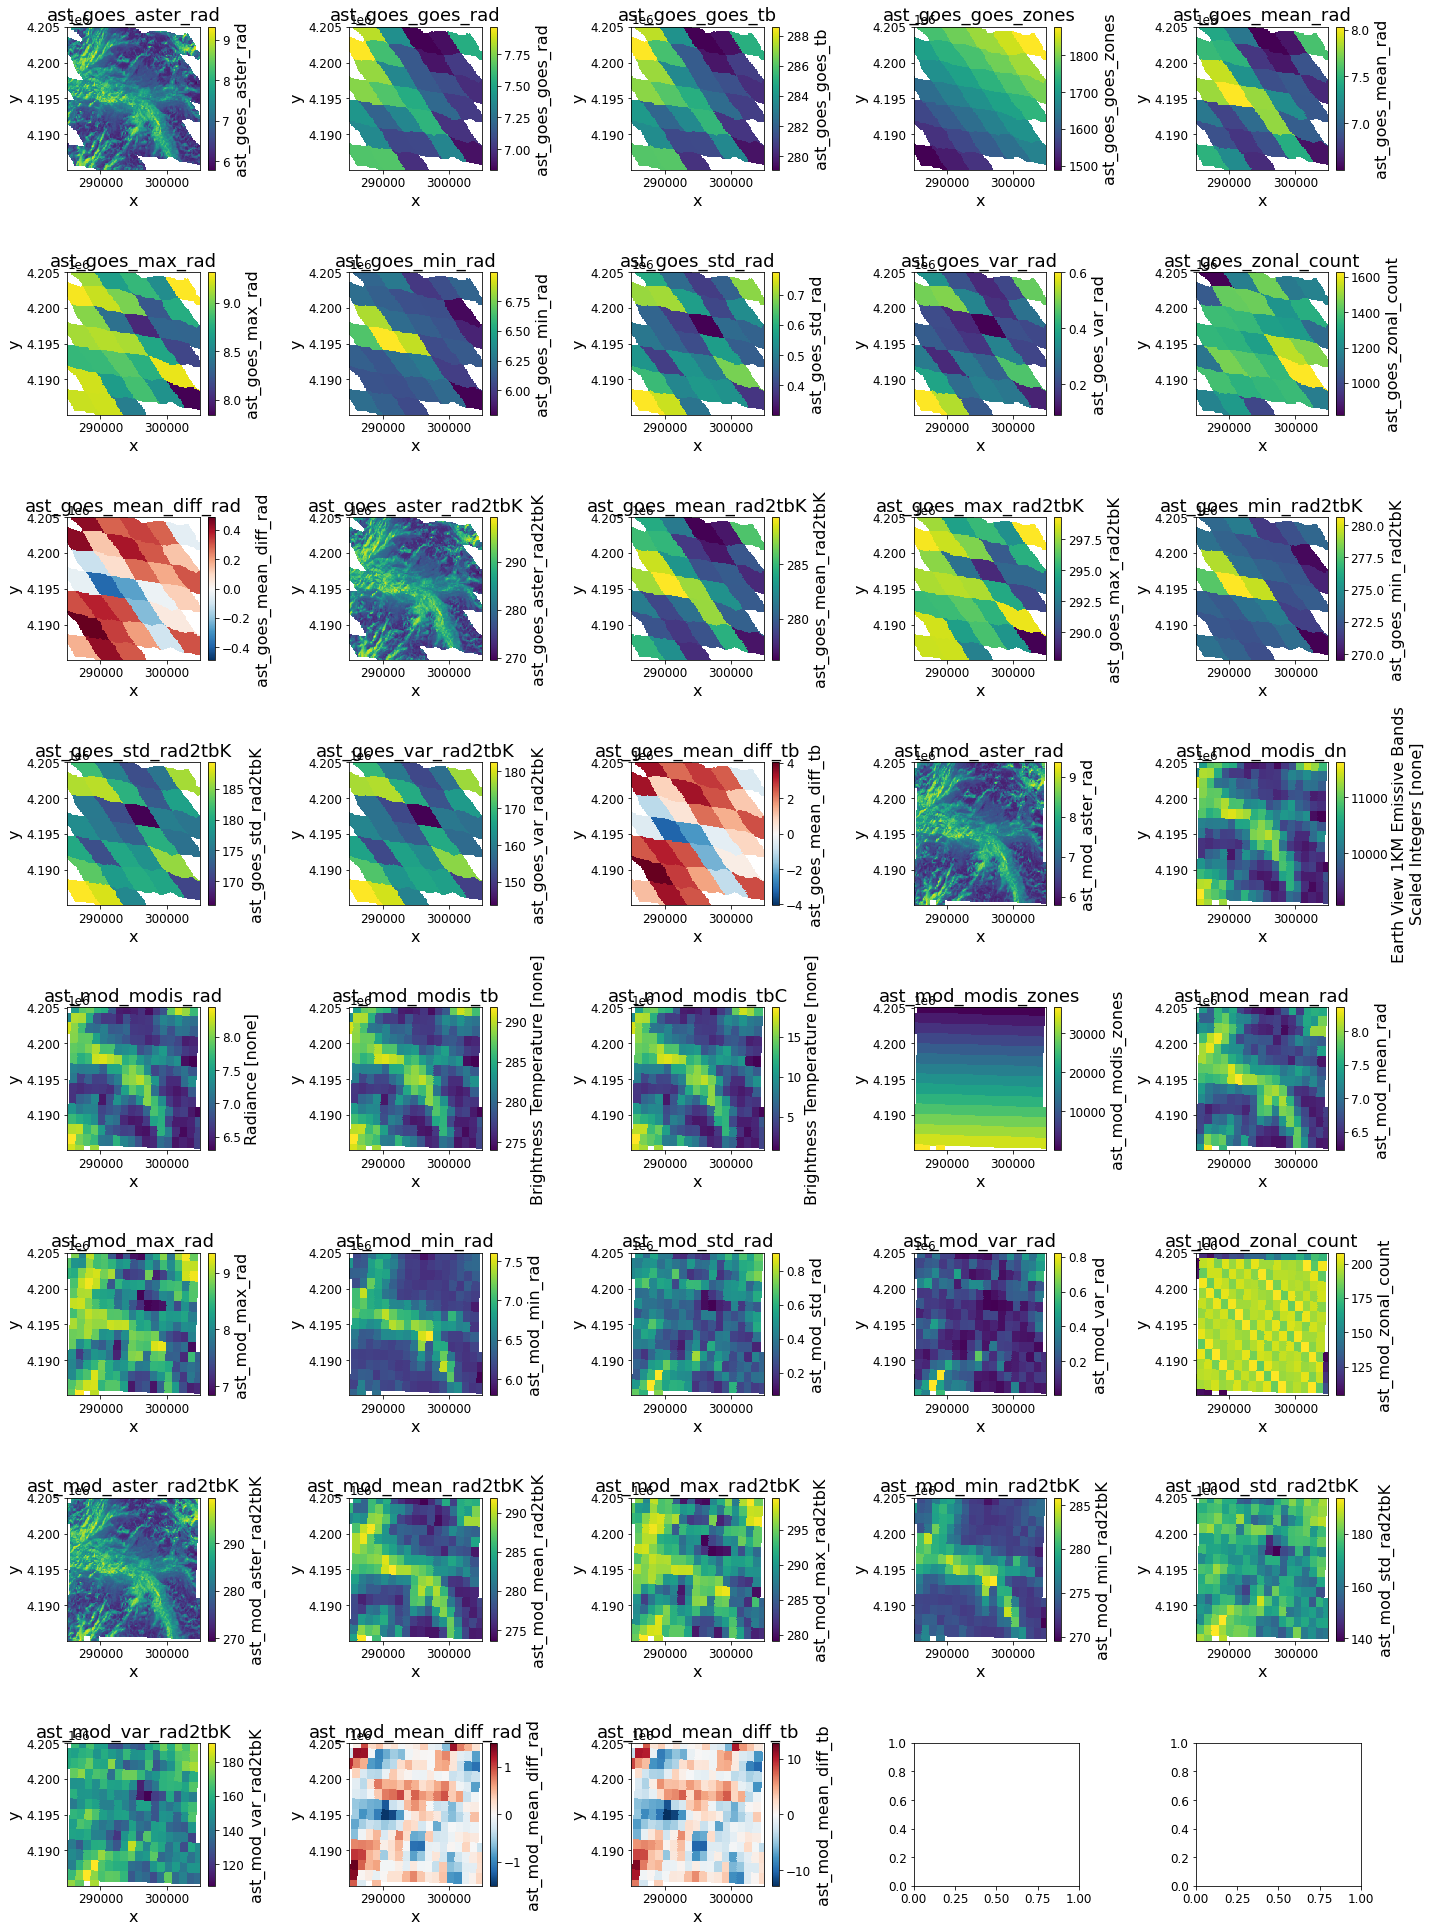

In [18]:
m = 12

fig, ax = plt.subplots(nrows=8, ncols=5, figsize=(20,27), tight_layout=True)
ax = ax.flatten()

for i, data_var in enumerate(ds_list[m]):
    ds_list[m][str(data_var)].plot(ax=ax[i])
    ax[i].set_title(str(data_var))